<a href="https://colab.research.google.com/github/premit88/Data_Mining/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installig the packages.
!pip install numpy pandas matplotlib imbalanced-learn scikit-learn nltk datasets

In [ ]:
# Load necessary libraries
import pandas as pd
import re
import nltk
from datasets import load_dataset
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')



# Loading the dataset to a variable
data = load_dataset("JulesBelveze/tldr_news")  ## other dataset was emotion

# Downlaod the data in the csv format.
for split, dataset in data.items():
    dataset.to_csv(f"my-dataset-{split}.csv", index=None)


# Reload dataset to a variable.
data_files = {
    "train": "my-dataset-train.csv",
    "test": "my-dataset-test.csv",
}


# Data cleaning

In [33]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Load stopwords and ensure they are in lowercase
stop_words = set(word.lower() for word in stopwords.words('english'))

def get_wordnet_pos(treebank_tag):
    """Converts treebank POS tags to WordNet POS tags."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None  # Signal that no conversion is possible

def clean_and_lemmatize_text(text):
    # Keep only ASCII characters
    text = text.encode("ascii", "ignore").decode()
    # Convert text to lowercase and remove URLs
    text = re.sub(r'https?://\S+', '', text.lower())
    # Remove non-alphabetic characters and extra spaces
    cleaned = re.sub(r'[^a-zA-Z\s]', '', text)
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    words = word_tokenize(cleaned)
    words_pos = nltk.pos_tag(words)  # Tag words with part-of-speech

    processed_words = []
    for word, pos_tag in words_pos:
        if word not in stop_words and word.strip():
            wordnet_pos = get_wordnet_pos(pos_tag)  # Convert to WordNet POS
            if wordnet_pos is None:
                lemmatized_word = word  # If no conversion was possible, skip lemmatization
            else:
                lemmatized_word = lemmatizer.lemmatize(word, wordnet_pos)
            processed_words.append(lemmatized_word)

    return ' '.join(processed_words)


def process_dataset(file_path):
    """Load, clean, and save a dataset."""
    data = pd.read_csv(file_path)

    # Combine 'Headline' and 'Content', then apply cleaning and lemmatization
    data['text'] = data['headline'] + ' ' + data['content']
    data['processed_text'] = data['text'].apply(clean_and_lemmatize_text)

    # Generate a processed file path
    processed_file_path = file_path.replace('.csv', '_processed.csv')

    # Save the processed dataset
    data[['processed_text', 'category']].to_csv(processed_file_path, index=False)

    print(f"Processing completed and saved to {processed_file_path}")
    return processed_file_path

# File paths for the datasets
train_file_path = '/content/my-dataset-train.csv'  # Adjust as needed
test_file_path = '/content/my-dataset-test.csv'  # Adjust as needed

# Process both datasets
processed_train_path = process_dataset(train_file_path)
processed_test_path = process_dataset(test_file_path)

Processing completed and saved to /content/my-dataset-train_processed.csv
Processing completed and saved to /content/my-dataset-test_processed.csv


# Thematic independence observed in our dataset

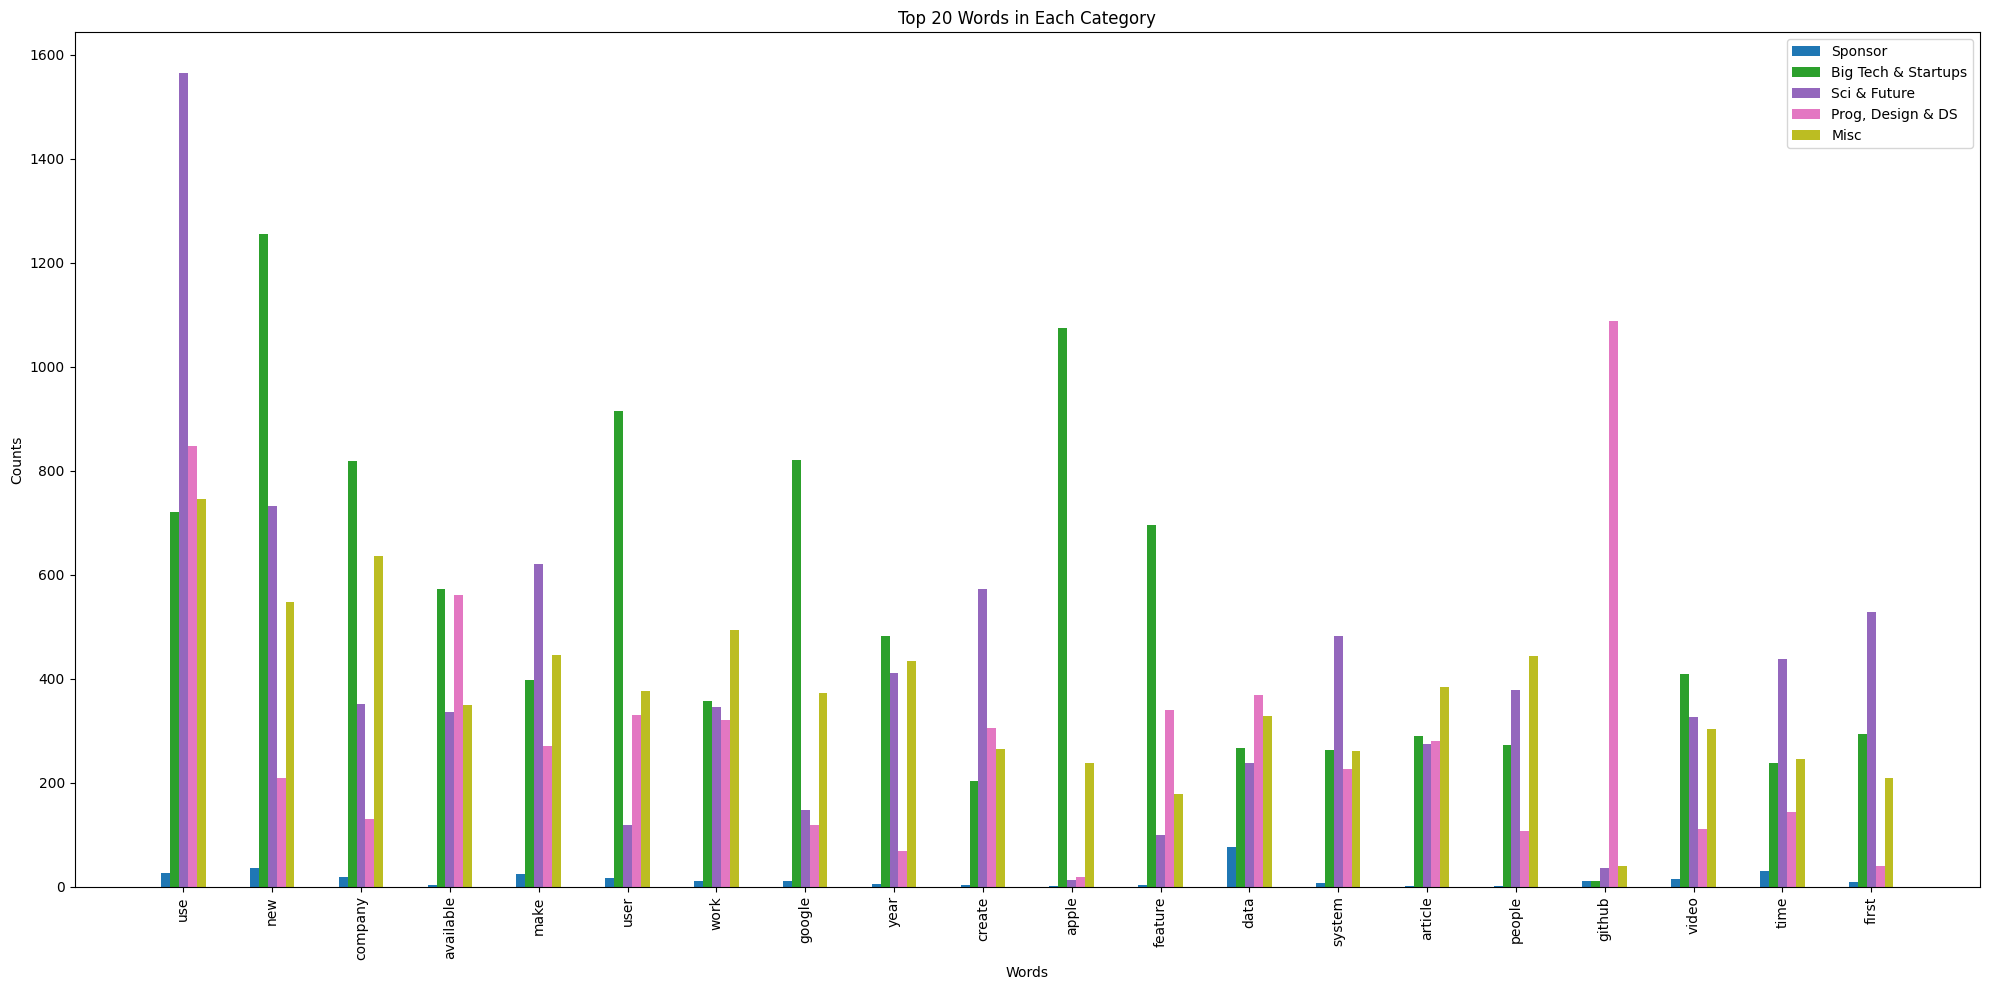

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Load the processed training dataset
processed_train_path = '/content/my-dataset-train_processed.csv'
data = pd.read_csv(processed_train_path)

# Mapping of numerical categories to specified category names
category_names = {
    0: 'Sponsor',
    1: 'Big Tech & Startups',
    2: 'Sci & Future',
    3: 'Prog, Design & DS',
    4: 'Misc'
}

# Replace numerical category codes with names
data['category_name'] = data['category'].map(category_names)

# Initialize the CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['processed_text'])
features = vectorizer.get_feature_names_out()

# Identify the overall top 20 words across the entire dataset
word_counts = np.array(X.sum(axis=0)).flatten()
top_20_words_indices = word_counts.argsort()[-20:][::-1]  # Indices of top 20 words
top_20_words = np.array(features)[top_20_words_indices]

# Function to plot the occurrence of the top 20 words in each category
def plot_top_20_words_occurrence(data, top_20_words, category_names):
    plt.figure(figsize=(20, 10))

    # Create a colormap to have a distinct color for each category
    cm = plt.get_cmap('tab20')
    colors = [cm(1.*i/len(category_names)) for i in range(len(category_names))]

    # Calculate occurrences of top 20 words in each category
    for idx, (category_code, category_name) in enumerate(category_names.items()):
        category_data = data[data['category'] == category_code]
        vectorizer = CountVectorizer(vocabulary=top_20_words)
        X_category = vectorizer.fit_transform(category_data['processed_text'])
        word_counts = np.array(X_category.sum(axis=0)).flatten()

        # Plot
        offset = np.arange(len(top_20_words))
        plt.bar(offset + idx*0.1, word_counts, width=0.1, label=category_name, color=colors[idx])

    plt.xticks(offset + 0.2, top_20_words, rotation=90)
    plt.title('Top 20 Words in Each Category')
    plt.ylabel('Counts')
    plt.xlabel('Words')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_top_20_words_occurrence(data, top_20_words, category_names)


# Imbalanced Data observed in our dataset

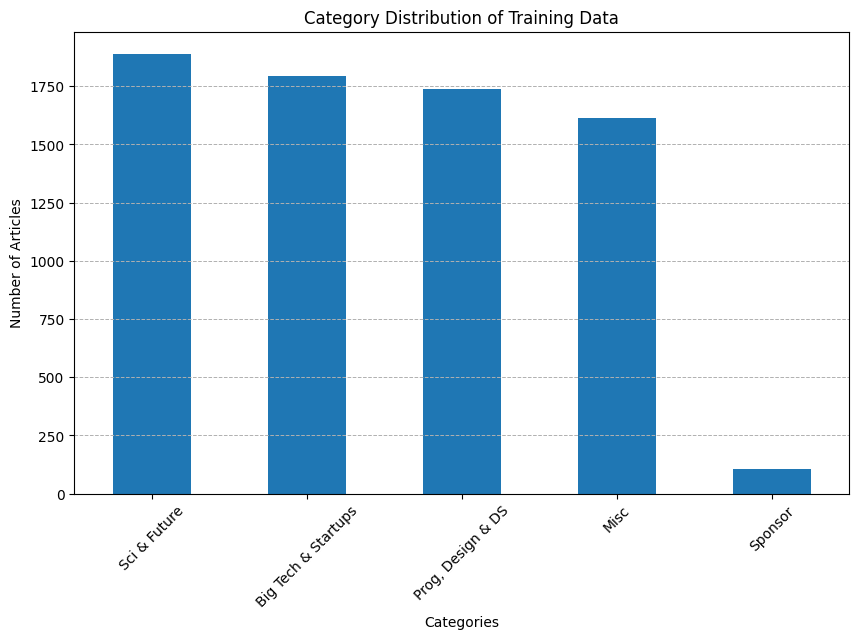

In [35]:
# Load the processed dataset
file_path = '/content/my-dataset-train_processed.csv'  # Adjust to your actual file path
data = pd.read_csv(file_path)

# Mapping of numerical categories to specified category names
category_names = {
    0: 'Sponsor',
    1: 'Big Tech & Startups',
    2: 'Sci & Future',
    3: 'Prog, Design & DS',
    4: 'Misc'
}

# Replace numerical category codes with names for plotting
data['category_name'] = data['category'].map(category_names)

# Check the balance of categories with names
category_counts_named = data['category_name'].value_counts()

# Plot a histogram with category names
plt.figure(figsize=(10, 6))
category_counts_named.plot(kind='bar')
plt.title('Category Distribution of Training Data')
plt.xlabel('Categories')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()



# Loading and Preparing the Training Data

In [36]:
import pandas as pd

# Specify the file paths for the training and test datasets
file_path_train = '/content/my-dataset-train_processed.csv'  # Adjust this to your training dataset path
file_path_test = '/content/my-dataset-test_processed.csv'  # Adjust this to your test dataset path

# Load the training dataset
data_train = pd.read_csv(file_path_train)

# Load the test dataset
data_test = pd.read_csv(file_path_test)


# Vectorization (Feature Extraction)

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Fit the vectorizer on the training data and transform the training data to document-term matrix
X_train = vectorizer.fit_transform(data_train['processed_text']).toarray()

# Transform the test data to document-term matrix using the same vectorizer
X_test = vectorizer.transform(data_test['processed_text']).toarray()

# Extract the category labels for the training and test data
y_train = data_train['category']
y_test = data_test['category']


# Balancing Data with SMOTE
We are oversampling the minority class in the training data.

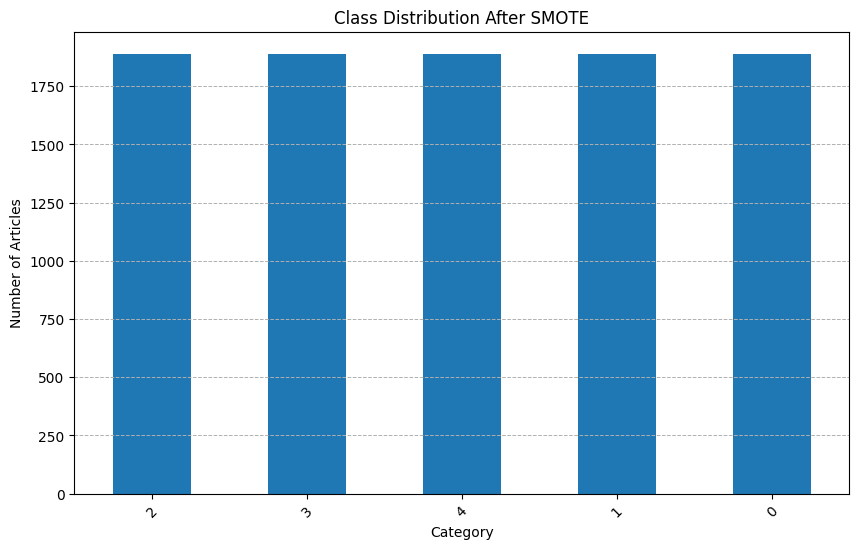

In [38]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


# Visualize the new class distribution
new_class_distribution = pd.Series(y_train_smote).value_counts()

plt.figure(figsize=(10, 6))
new_class_distribution.plot(kind='bar')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()

# Training the Naive Bayes Classifer
Train a Multinomial Naive Bayes classifier, which is suitable for classification with discrete features (like word counts or TF-IDF) for text classification tasks.

In [39]:
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB()
classifier.fit(X_train_smote, y_train_smote)


MultinomialNB()

# Evaluate the classifier on Training Data.

In [40]:
from sklearn.metrics import classification_report

# Predicting the categories for the training dataset
y_train_pred = classifier.predict(X_train_smote)

# Generating the classification report for the training data
report = classification_report(y_train_smote, y_train_pred, target_names=category_names.values())
print("Classification Report of Training Data:\n", report)


Classification Report of Training Data:
                      precision    recall  f1-score   support

            Sponsor       0.97      1.00      0.99      1890
Big Tech & Startups       0.77      0.85      0.81      1890
       Sci & Future       0.78      0.80      0.79      1890
  Prog, Design & DS       0.89      0.93      0.91      1890
               Misc       0.75      0.59      0.66      1890

           accuracy                           0.83      9450
          macro avg       0.83      0.83      0.83      9450
       weighted avg       0.83      0.83      0.83      9450



# Saving the classifer and Vectorizer

In [41]:
import joblib

# Save the classifier
joblib.dump(classifier, '/content/naive_bayes_classifier.pkl')

# Save the vectorizer
joblib.dump(vectorizer, '/content/tfidf_vectorizer.pkl')


['/content/tfidf_vectorizer.pkl']

# Using the classifer on Test Data

In [42]:
# Load the classifier and vectorizer
classifier = joblib.load('/content/naive_bayes_classifier.pkl')
vectorizer = joblib.load('/content/tfidf_vectorizer.pkl')

# Load your test data
file_path_test = '/content/my-dataset-test_processed.csv'  # Adjust this to your test dataset path
data_test = pd.read_csv(file_path_test)

# Vectorize the test data
X_test = vectorizer.transform(data_test['processed_text']).toarray()

# Predict
predictions = classifier.predict(X_test)

# You can then compare these predictions with the actual labels to evaluate the classifier


# Evalute your test data.

In [43]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

# Step 1: Load the saved classifier and vectorizer
classifier = joblib.load('/content/naive_bayes_classifier.pkl')
vectorizer = joblib.load('/content/tfidf_vectorizer.pkl')

# Step 2: Prepare the test data
# Assuming 'processed_test_path' is the path to your processed test dataset
data_test = pd.read_csv(processed_test_path)
X_test = vectorizer.transform(data_test['processed_text']).toarray()  # Transform the test data
y_test = data_test['category']  # True labels of the test data

# Step 3: Predict on the test data
y_pred = classifier.predict(X_test)

# Step 4: Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Detailed classification report
print("\nClassification Report of Test Data:\n")
print(classification_report(y_test, y_pred, target_names=category_names.values()))


Accuracy: 73.93%

Classification Report of Test Data:

                     precision    recall  f1-score   support

            Sponsor       0.62      0.93      0.74        14
Big Tech & Startups       0.70      0.83      0.76       200
       Sci & Future       0.75      0.75      0.75       225
  Prog, Design & DS       0.89      0.91      0.90       202
               Misc       0.54      0.37      0.44       153

           accuracy                           0.74       794
          macro avg       0.70      0.76      0.72       794
       weighted avg       0.73      0.74      0.73       794



# Confusion Matrix because our data was imbalanced.
## Interpreting the Matrix
1.   Each cell [i, j] in the matrix shows the number of instances of class i (actual) that were predicted as class j (predicted).
2.   Main Diagonal: The cells along the main diagonal from the top left to the bottom right ([i, i] for all i) show the number of correct predictions for each class. High numbers along this diagonal indicate good performance.
3.   Off-Diagonal: The off-diagonal cells show misclassifications. For cell [i, j], the number indicates instances of class i being misclassified as class j. High numbers in these cells indicate areas where the model is confusing classes.

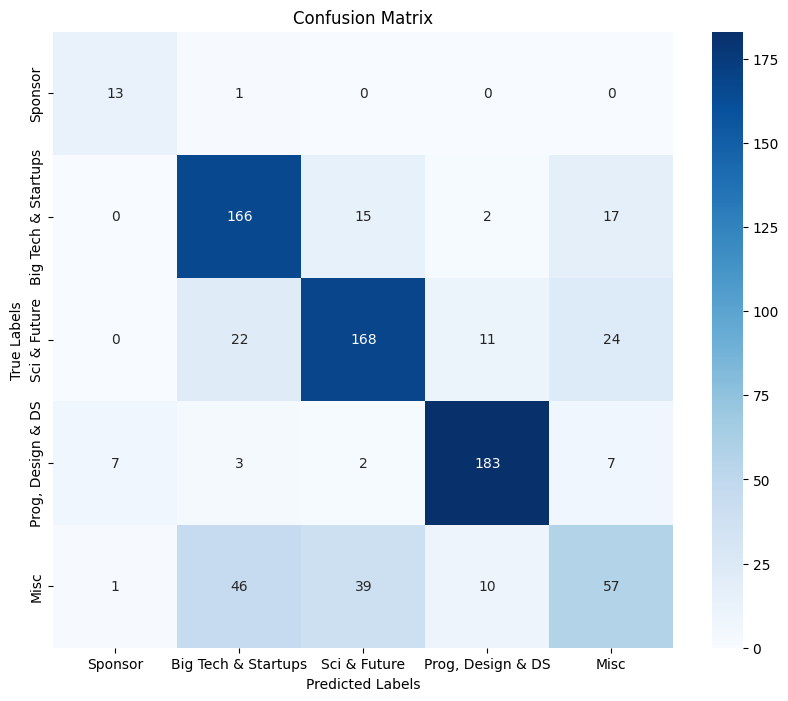

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming y_test contains the true labels and y_pred contains the predicted labels from your classifier
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=category_names.values(), yticklabels=category_names.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## Tokenizing our csv file and then applying ranking function (BM25) for search engine

In [45]:
!pip install rank-bm25
from rank_bm25 import BM25Okapi

# Load the original and processed training datasets
train_original_path = '/content/my-dataset-train.csv'
train_processed_path = '/content/my-dataset-train_processed.csv'
data_train_original = pd.read_csv(train_original_path)
data_train_processed = pd.read_csv(train_processed_path)

# Load the original and processed test datasets
test_original_path = '/content/my-dataset-test.csv'
test_processed_path = '/content/my-dataset-test_processed.csv'
data_test_original = pd.read_csv(test_original_path)
data_test_processed = pd.read_csv(test_processed_path)

# Tokenize the processed text from training and test datasets
tokenized_corpus_train = [text.split() for text in data_train_processed['processed_text']]

# Initialize BM25 with the tokenized training corpus
bm25 = BM25Okapi(tokenized_corpus_train)

def bm25_search(query, top_n=4):
    # Tokenize the query
    query_tokens = query.lower().split()

    # Get scores for each document in the training corpus
    train_scores = bm25.get_scores(query_tokens)

    # Get the top scoring documents indices from the training data
    top_train_indices = train_scores.argsort()[::-1][:top_n]

    # Extract top documents from both original training dataframes
    top_docs_train_original = data_train_original.iloc[top_train_indices]

    # Now score the test data separately
    tokenized_corpus_test = [text.split() for text in data_test_processed['processed_text']]
    bm25_test = BM25Okapi(tokenized_corpus_test)
    test_scores = bm25_test.get_scores(query_tokens)
    top_test_indices = test_scores.argsort()[::-1][:top_n]
    top_docs_test_original = data_test_original.iloc[top_test_indices]

    return top_docs_train_original, top_docs_test_original, train_scores[top_train_indices], test_scores[top_test_indices]

# Example usage
query = "web animation performance fundamentals"
top_docs_train_original, top_docs_test_original, top_train_scores, top_test_scores = bm25_search(query)
print("Top Training Documents Based on BM25 Scores:")
print(top_docs_train_original)
print("\nBM25 Scores for Top Training Documents:")
print(top_train_scores)

print("\nTop Test Documents Based on BM25 Scores:")
print(top_docs_test_original)
print("\nBM25 Scores for Top Test Documents:")
print(top_test_scores)


Top Training Documents Based on BM25 Scores:
                                               headline  \
5924  Web Animation Performance Fundamentals – How t...   
6617                               Motion One (Website)   
5409                    CSS Animation 101 (Open Source)   
3323                               lax.js (GitHub Repo)   

                                                content  category  
5924  Web pages are interactive animations played ba...         3  
6617  Motion One is an animation library built on th...         3  
5409  This is a 95 page open source guide to web ani...         2  
3323  lax.js allows web developers to easily create ...         3  

BM25 Scores for Top Training Documents:
[18.59076795 13.49129634 13.03201027 13.03201027]

Top Test Documents Based on BM25 Scores:
                                              headline  \
753                        Additive Animations in CSS    
129                      How to animate SVG signature    
200  How Dis